# GNN Code, mostly taken from Luke van Poppering

### Latex Macros
$\newcommand{\Re}[1]{{\mathbb{R}^{{#1}}}}
\newcommand{\Rez}{{\mathbb{R}}}$

In [1]:
%load_ext autoreload
%autoreload 2
#%tableofcontents

In [2]:
import torch
import torch_scatter
import torch_sparse
import torch_geometric
import tqdm.auto
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import GNN_Tools as GNNT

In [3]:
### We use the famous 'Karate Club' network as a test case. Our task is to
### predict the community to which each node belongs; formally, this would be
### called transductive binary node classification.

import networkx as nx
G = nx.karate_club_graph()

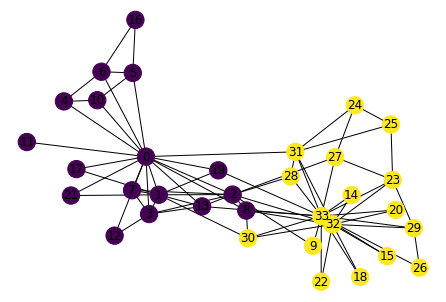

In [4]:
### Plot the network. We see it consists of a total of 34 nodes (numbered below 
### 0-33). Colors indicate class membership.
labels = [0 if G.nodes[idx]['club'] == 'Mr. Hi' else 1 for idx in range(len(G.nodes))]
pos = nx.drawing.layout.spring_layout(G)
nx.drawing.draw(G,pos=pos,with_labels=True,node_color=labels) 

In [5]:
### Write edge list to file.
### The attributes are synthetic
torch.manual_seed(0)
with open('edges.txt','w') as f:
  for edge in list(G.edges):
    f.write(f'{edge[0]} {edge[1]} {1.0}\n')

### Write node metadata to file. Nodes belonging to class '0' have features
### drawn from N(1,1). Nodes belonging to class '1' have features drawn from 
### the standard normal. So the features are the class label + 16 random numbers, 
### where the mean depends on the class. 
nb_Gnodes = len(list(G.nodes))
nb_rand_features = 3   # change value for experimentation
rands = np.random.randn(nb_Gnodes, 16)
with open('nodes.txt','w') as f:
  for node in list(G.nodes):
      if G.nodes[node]['club'] == 'Mr. Hi':
          X_str = " ".join([str(.5 + rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 0 ' + X_str + ' \n')
      elif G.nodes[node]['club'] == 'Officer':
          X_str = " ".join([str(rand) for rand in np.random.randn(nb_rand_features)])
          f.write(f'{node} 1 ' + X_str + ' \n')

### Read files into _Graph_ object.
karate_club_graph = GNNT.Graph()
karate_club_graph.read_edges('edges.txt')
karate_club_graph.read_node_metadata('nodes.txt')

In [6]:
len(G.nodes)
import numpy.linalg as alg

In [7]:
graph = karate_club_graph

Linear model is 
$$ H^{n+1} = A H^n W $$
where $H\in \Re{N\times d}$, $A\in\Re{N\times N}$, and $W\in\Re{d\times d}$ and $d$ is the number of features. In our synthetic example, we have 16 features, one label. `

In [42]:
### Create a hand-crafted GNN without using a formal model.

def model(G, graph):
    """
    G is a networkx graph
    graph is an instance of the Graph class (Luke VP)
    """
    nb_nodes = len(G.nodes)
    nb_edges = len(G.edges)
    # print(f"nb nodes: {nb_nodes}, nb_edges: {nb_edges}")
    A = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
    # Check that graph is undirected
    # print("norm(A): ", alg.norm(A))
    # print("det(A): ", alg.det(A))  # Determinant is A
    # print("det(A+I): ", alg.det(A+np.eye(nb_nodes)))
    # print("||A-A.T||=0 if undirected graph: ", alg.norm(A-A.T))
    #print(A - A.T)
    #print(alg.norm(A - A.T))
    # print(np.sort(alg.eig(A)[0]))
    An = np.eye(nb_nodes) + A
    Asq = alg.inv(np.sqrt(An))
    An = Asq @ An * Asq
    # print("det(An): ", alg.det(An))
    eig = alg.eig(An)[0]
    # print("eig= ", eig)
    # print(np.sum(A), 34*34)  # Sparse: #1/#nodes = 156/1156
    ## Ainv = A^{-1} is not sparse. Therefore, sparsity property is lost. So for 
    ## sparse graphs, techniques that can take advantage of sparsity are preferred.
    
    H0 = graph.node_metadata
    # Use -1 in case the matrix eventually changes number of dimensions
    nb_features = H0.shape[-1]   # last index
    # print("nb_features: ", nb_features)
    # Initialize W with random numbers and allow gradient 
    # computation of cost function with respect to (wrt) W
    W = torch.rand(nb_features, nb_features, requires_grad=True) 
    
    print(H0.shape, A.shape, W.shape)
    A = torch.tensor(A, dtype=torch.float32)
    
    # Using a sigmoid woudl reduce the range
    # Using ReLu would not reduce the range so normalizaiton must be done
    #   diffently
    H = H0
    
    def cost(H, edge_index, node_metadata):
        """
        summation over all edges
        """
        costf = 0.
        for e in edge_index:
            i, j = e
            costf += (H[i,:] - H[j,:]) @ (H[i,:] - H[j,:])
        return costf
        
    print("H0: ", torch.norm(H0), "H1: ", torch.norm(H))
    
    for iterat in range(5):
        print("----------------------------")
        H = A @ H @ W

        costf = cost(H, graph.edge_index, graph.node_metadata)
        print("costf= ", costf)
        with torch.no_grad():
            costf.backward(retain_graph=True)  # otherwise graph is discarded. How to regenerate it?
            lr= 1.e-2
            W  = W - lr * W.grad
            W = torch.nn.Parameter(W)
        print("W: ", W)
        print("new norm(W): ", torch.norm(W))
        
    # ||W|| goes to \infy

In [43]:
# print(graph.edge_index)
          
model(G, graph)
A = nx.linalg.graphmatrix.adjacency_matrix(G).toarray()
# Check that graph is undirected
print("||A-A.T||=0 if undirected graph: ", alg.norm(A-A.T))

torch.Size([34, 4]) (34, 34) torch.Size([4, 4])
H0:  tensor(12.2859) H1:  tensor(12.2859)
----------------------------
costf=  tensor(28532.0684, grad_fn=<AddBackward0>)
W:  Parameter containing:
tensor([[ -64.5762,  -52.3621,  -38.9226,  -60.8553],
        [-116.6835,  -84.2571,  -60.2012, -117.7707],
        [ -86.6641,  -56.9653,  -41.1387,  -91.2008],
        [ -73.7577,  -54.1420,  -34.2501,  -77.2887]], requires_grad=True)
new norm(W):  tensor(294.3170, grad_fn=<CopyBackwards>)
----------------------------
costf=  tensor(8.7030e+09, grad_fn=<AddBackward0>)
W:  Parameter containing:
tensor([[183348.4531, 135481.0156,  94838.3125, 185114.2500],
        [222116.5000, 162051.7500, 113587.5078, 225185.3438],
        [ 92187.8125,  67839.3906,  47526.0938,  93192.0547],
        [214165.1719, 157615.8906, 110345.9688, 216531.8750]],
       requires_grad=True)
new norm(W):  tensor(623102.3125, grad_fn=<CopyBackwards>)
----------------------------
costf=  tensor(6.9922e+23, grad_fn=<AddBa

nb nodes: 34, nb_edges: 78
0.0


In [ ]:
### We create a Simple_GNN w/ 16 input features, 
### 64 intermediate features, and an output dimension
### of 2 (as this is a binary classification problem).
model = Simple_GNN(16,64,2,3,aggregation_mode='mean')

### We initialize the GNN_Trainer and train for 200
### epochs on CPU. 
trainer = GNN_Node_Trainer(karate_club_graph,num_epochs=200,random_seed=1)
predictions = trainer(model)

Train Loss: 0.011	Test Loss: 0.394: 100%|██████████| 200/200 [00:01<00:00, 117.86it/s]


In [11]:
G.nodes.

AttributeError: 'NodeView' object has no attribute 'shape'

In [25]:
a = torch.tensor([2,3,4,])
b = a.detach()

In [26]:
a, b

(tensor([2, 3, 4]), tensor([2, 3, 4]))